# Lecture 3.8: Learning Better Pt.2

[**Lecture Slides**](https://docs.google.com/presentation/d/1Gb_jGPy0YIH8qDi2AgBQEwaoT8uPbyG_5N3dHPlthrM/edit?usp=sharing)

This lecture, we are going to regularize a model to improve its generalization.

**Learning goals:**

- overfit a polynomial regression model
- use ridge regularization to prevent overfitting
- analyse the effect of the regularization weight on model parameter sizes
- train a regularized logistic regression model with polynomial features

## 1. Introduction

This is part 2 of "Learning Better". We'll be using the same dataset and trying to solve the same task as notebook 3.7. If you haven't been through notebook 3.7, please start there.

## 2. High Polynomial Regression

Let's load our instagram planning dataset from csv into a `DataFrame`:

In [1]:
import pandas as pd

df = pd.read_csv('instagram_planning.csv')
df.head()

,planned_minutes,actual_minutes
0,2.617826,3.230395
1,3.559634,3.931186
2,4.903828,7.404192
3,7.075610,9.230352
4,7.243637,7.204204


To refresh our minds since last lecture, let's visualize the dataset again:

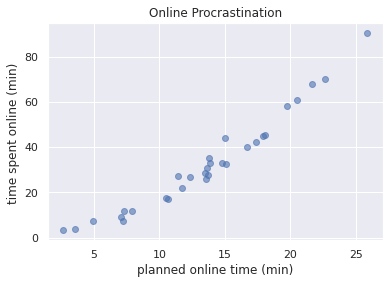

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df['planned_minutes'], df['actual_minutes'], alpha=0.6)

ax.set_xlabel('planned online time (min)')
ax.set_ylabel('time spent online (min) ')
ax.set_title('Online Procrastination');

Remember the single feature is the number of minutes we _plan_ to spend online, and the numerical label is the _actual_ amount of time we spend online. 📱

In notebook 3.7, we had success adding polynomial features to our linear regression model. The resulting non-linear hypothesis was a better fit to the labels. We are therefore tempted to power up the model even more... let's turn it up all the way to 11! 🎸

Let's create our feature matrix and label vector:

In [3]:
X = df['planned_minutes'].values.reshape(-1, 1)
y = df['actual_minutes'].values

Then add the polynomial features of degree 11, and standardize them using sklearn proprocessors:

In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(11, include_bias=False)
poly = poly.fit(X)
X_poly = poly.transform(X)

scaler = StandardScaler()
scaler = scaler.fit(X_poly)
X_poly_scaled = scaler.transform(X_poly)

Finally, we can train our superpowered polynomial regression:

In [5]:
reg = LinearRegression().fit(X_poly_scaled, y)

Just like notebook 3.7, we can visualize the optimized hypothesis by using `.predict()`. Let's put this code in a function, so that we may reuse it later:

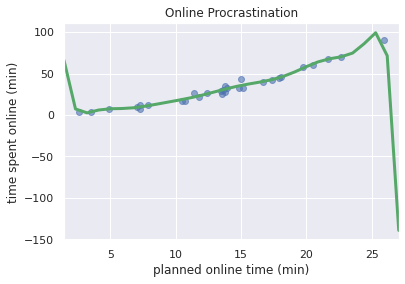

In [6]:
import numpy as np

def plot_polynomial_regression(X, y, reg, poly, scaler):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot the examples
    ax.scatter(X, y, alpha=0.6)

    # create feature matrix
    xmin, xmax = ax.get_xlim()
    x_line = np.linspace(xmin, xmax, 30).reshape(-1, 1)

    # apply feature transformations
    x_line_poly = poly.transform(x_line)
    x_line_poly_scaled = scaler.transform(x_line_poly)

    # predict
    y_line = reg.predict(x_line_poly_scaled)

    # plot the hypothesis
    ax.plot(x_line, y_line, c='g', linewidth=3)

    # formatting
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('planned online time (min)')
    ax.set_ylabel('time spent online (min)')
    ax.set_title('Online Procrastination');
    
plot_polynomial_regression(X, y, reg, poly, scaler)

... what happened? we were expecting awesome modeling power, but this hypothesis looks all crooked! The value are shooting up for small values of `planned_minutes`, and dropping for large values of the feature, both of which make no sense. 😜

This is a typical example of _overfitting_. The model is too powerful and tries to fit the noise rather than the underlying pattern.

One way of preventing this from happening, is to chill out with the degree polynomial features and maybe keep it to 2 like last lecture. 💆‍♂️ However sometimes it is difficult to know which exact polynomial degree, or which model "power", to use. Therefore, a more robust way of preventing overfitting is _regularization_.


## 3. Ridge Regression

Overfitting typically happens when some of the model parameters become very large. Large $\theta$ suggests "abrupt" variations in the hypothesis, and is a sign that the model is trying to fit noise.

We can check the model parameters inside the fitted `LinearRegression` instance:

In [7]:
theta = np.append(reg.intercept_, reg.coef_)
theta

array([ 3.24854490e+01, -5.40737175e+03,  8.68286292e+04, -6.93364738e+05,
        3.41854156e+06, -1.11884686e+07,  2.50269749e+07, -3.84363559e+07,
        3.98334174e+07, -2.65879849e+07,  1.03072092e+07, -1.76137160e+06])

Recall that we have added polynomial features of degree 11. As expected, $\theta$ is a vector of length 12: one $\theta_{i}$ per feature, plus one intercept term.

Some of these $\theta$ values are _very_ large! We're seeing quite a few values in the tens of millions. There is no universal guideline about an "appropriate" range for $\theta$ values, but keep in mind that our features are standardized, and our labels are in the range of hundreds. Thus, there is no reason for $\theta_{i} > 1000000$. 🚓

Ridge regularization penalizes large $\theta_{i}$ values by adding a regularization term to the cost function. 

$$ 
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)} - y^{(i)})^{2} + \alpha \sum_{j=1}^{n}\theta_{j}^{2}
$$

Hopefully this can help keep our model parameters under control!

sklearn directly integrates ridge regularization into the model api. Therefore all we have to do is switch the vanilla `LinearRegression` model with a [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) instance:

In [8]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1, random_state=0).fit(X_poly_scaled, y)

It's that easy! sklearn takes care of choosing the correct regularized cost function, and optimizing it using gradient descent. If you need a refresher on what these steps are, check out lecture 3.5 

We can now check if our model parameters are better behaved:

In [9]:
theta = np.append(reg.intercept_, reg.coef_)
theta

array([32.48544896,  7.99927812,  6.24954698,  4.11008076,  2.40993484,
        1.25208941,  0.5111243 ,  0.04557775, -0.24849148, -0.4371084 ,
       -0.55958974, -0.63886071])

All $\theta_{i}$ are in the range of tens, so the ridge regularization worked! Our model is less likely to be overfit. We can verify this graphically: 

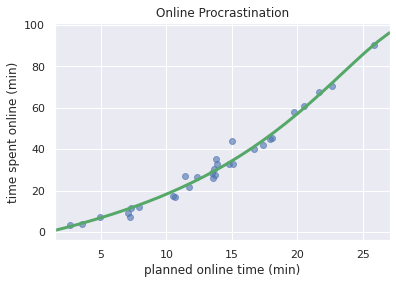

In [10]:
plot_polynomial_regression(X, y, reg, poly, scaler)

The hypothesis no longer seems to model noisy data points. Instead it was "smoothed" by our ridge regularization, and we can expect it to generalize better.

ℹ️ Note how the hypothesis is very similar to the polynomial regression of degree 4 we have trained in the final task of last lecture. This agrees with the fact that model parameter values beyond $\theta_{4}$ are quite small compared to the rest. Small $\theta_{i}$ values mean that the features don't contribute much to the overall hypothesis. This is like saying that we gave extra "polynomial power" to the regression model, but the optimization procedure found this extra power unnecessary. 💁‍♂️This is an indication that polynomial features of degree 11 might have been overkill here!

## 4. Analysis

We haven't talked about the `Ridge` argument: `alpha`. The regularization term added to the MSE cost function is multiplied by a _regularization weight_ , $\alpha$. This allows us to control the strength of the regularization penalty. Let's investigate what is the effect of $\alpha$ on our model parameter values $\theta$.

We'll train 100 different `Ridge` regression models, each with a different value of $\alpha$. We can then plot the values of $\theta$ and observe their relationship:


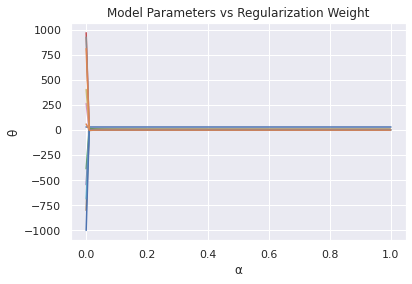

In [11]:
def train_ridge(alpha, X, y):
    reg = Ridge(alpha=alpha).fit(X_poly_scaled, y)
    return np.append(reg.intercept_, reg.coef_)
    
alphas = np.linspace(0.000001, 1, 100)
thetas = [train_ridge(alpha, X, y) for alpha in alphas]
thetas = np.array(thetas)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(0, thetas.shape[1]):
    theta = thetas[:, i]
    ax.plot(alphas, theta)
    
ax.set_xlabel('α')
ax.set_ylabel('θ')
ax.set_title('Model Parameters vs Regularization Weight');

Each colored line is a parameter $\theta_{i}$. We can spot a reduction in the absolute value of the model parameters, but it happens all scrunched up for very small values of $\alpha$. Let's "zoom in" a little:

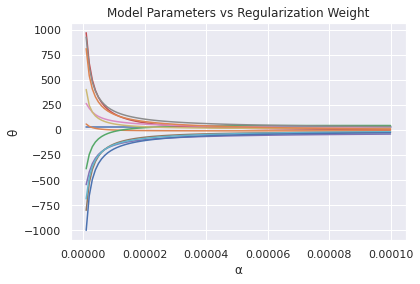

In [12]:
alphas = np.linspace(0.000001, 0.0001, 100)
thetas = [train_ridge(alpha, X, y) for alpha in alphas]
thetas = np.array(thetas)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(0, thetas.shape[1]):
    theta = thetas[:, i]
    ax.plot(alphas, theta)
    
ax.set_xlabel('α')
ax.set_ylabel('θ')
ax.set_title('Model Parameters vs Regularization Weight');


Here we can clearly see the effect of $\alpha$ on the model parameters. For big $\alpha$, the effect of the regularization is stronger, and the large values of $\theta$ are more penalized. This trend slows down and the $\theta$ values converge around $\alpha \approx 0.0001$. This means that for this regression model, there is no additional regularization provided by $\alpha > 0.0001$

ℹ️ Notice that this $\alpha$ threshold of 0.0001 is much smaller than the default 1.0 used in the [section above](#3.-Ridge-Regression). If a regularized model is _underfit_ , it can be helpful to lower $\alpha$ in order to increase modeling power.

## 5. Ridge Classification

The penalty term added to the cost function in ridge regularization isn't specific to the MSE cost function... it can also be applied to our logistic regression's cross-entropy cost function! 

You are going to learn how to apply ridge regularization in classification task _all on your own_. No need to worry, this is very similar to the sections above since sklearn has a model api class especially dedicated to ridge regularization for logistic regression: [`RidgeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html).

💪💪💪 Train a ridge regularized polynomial logistic regression classifier. And then tell your friends, because that's a badass model name. 😎Here's a few steps to help out:
- Load the `wine_quality.csv` dataset
- use the `sulphates` and `alcohol` columns as features, and the `tasty` column as categorical label
- store the feature matrix and label vector in two NumPy `ndarray`s, `X` and `y`
- use a polynomial feature preprocessor named `poly` and a feature scaler called `scaler`
- name your `RidgeClassifier` instance `clf` (for classifier)
- use polynomial degree 5, and default regularization weight 1.0

You are only expected to _fit_ your model. You can then run the two cells below to unit test your code, and visualize the non-linear decision boundary.

In [13]:
import pandas as pd

import numpy as np

from sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler

df = pd.read_csv('wine_quality.csv')

#Features and label

X = np.asarray(df[['sulphates', 'alcohol']])

y = np.asarray(df['tasty'])

#polynomial 

poly = PolynomialFeatures(5, include_bias=False)

poly = poly.fit(X)

X_poly = poly.transform(X)

#Feature Scale

scaler = StandardScaler()

scaler = scaler.fit(X_poly)

X_poly_scaled = scaler.transform(X_poly)

#Ridge Classifier

clf = RidgeClassifier(alpha = 1.0).fit(X_poly_scaled,y)




In [14]:
def plot_decision_boundary(ax, X, poly, scaler, clf):
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    X_mesh = np.c_[xx1.ravel(), xx2.ravel()]
    X_mesh_poly = poly.transform(X_mesh)
    X_mesh_poly_scaled = scaler.transform(X_mesh_poly)
    Z = clf.predict(X_mesh_poly_scaled)

    # Put the result into a color plot
    Z = Z.reshape(xx1.shape)
    ax.contour(xx1, xx2, Z, cmap=plt.cm.Greens)

def plot_classification(X, y, poly, scaler, clf):
    colors = sns.color_palette('husl').as_hex()

    fig = plt.figure(dpi=120)
    ax = fig.add_subplot(111)

    # plot points
    positives = X[y == 1]
    negatives = X[y == 0]
    ax.scatter(positives[:, 0], positives[:, 1], alpha=0.4, s=8,c=colors[0], label='tasty')
    ax.scatter(negatives[:, 0], negatives[:, 1], alpha=0.4, s=8, c=colors[4], label='not tasty')


    # plot decision boundary
    plot_decision_boundary(ax, X, poly, scaler, clf)

    # formatting
    ax.set_ylim((-2, 4))
    ax.set_xlim((-2, 4))
    ax.set_xlabel('Sulphates (norm)')
    ax.set_ylabel('Alcohol (norm)')
    ax.legend()
    ax.set_title('Wine Tastiness vs Sulphates & Alcohol Contents');


Success! 🎉


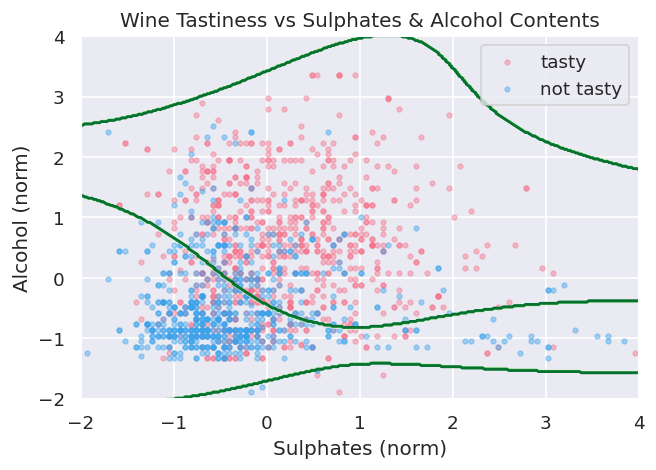

In [15]:
import math

def test_classification():
    X_predict = np.array([1, -1]).reshape(1, 2)
    X_predict_poly = poly.transform(X_predict)
    X_predict_poly_scaled = scaler.transform(X_predict_poly)
    y_predict = clf.decision_function(X_predict_poly_scaled)
    assert math.isclose(y_predict, -0.05693, rel_tol=1e-4)
    print('Success! 🎉')

test_classification()
plot_classification(X, y, poly, scaler, clf)

Congrats on training your first model from scratch! 🎊

🧠 Can you tell which sides of the decision boundary are positive vs negative predictions?  

🧠 Are there graphical signs that the regularization worked?

## 6. Summary

Today, we learned about **regularization**. First we defined **overfitting**, and how avoiding it promises a better model **generalization**. We then explained how to avoid overfitting, by preventing model parameters values from getting too big. We understood that this can be implemented by adding an extra term to the model's **cost-function**. We also highlighted how a data scientist must find the right **balance** between underfit and overfit models. We tested the **ridge** regularization technique on a polynomial regression model of degree 11. We then analysed the influence of the **regularization weight**, $\alpha$, before implementing our own **regularized classifier**.

# Resources

## Core Resources

- [**Slides**](https://docs.google.com/presentation/d/1Gb_jGPy0YIH8qDi2AgBQEwaoT8uPbyG_5N3dHPlthrM/edit?usp=sharing)
- [Regularization in ML](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a)  
Comprehensive list of cost-function regularization methods

## Additional Resources

- [Visualizing Ridge Regression](https://xavierbourretsicotte.github.io/animation_ridge.html)